# Real-ESRGAN 学习笔记
Real-ESRGAN的副标题是“Training Real-World Blind Super-Resolution with Pure Synthetic Data”，它旨在ESRGAN框架的基础上，构建一个模拟真实相机/网络传播压缩等退化方式的模型，并依赖这个模型，创建一个完全合成的数据对集，以此训练一个更加拟合真实环境的超分辨率网络。

在经典的图像退化模型中，主要由以下四个部分组成：
$$
x = \mathcal{D}(y) = \left[ (y \circledast k) \downarrow_r + n \right]_{\mathrm{JPEG}}
$$
- 使用高斯模糊核k进行卷积。
- 下采样r倍。有三种下采样方式：
  - 最近邻插值：对每个像素取其最近的邻居像素值。
  - 双线性插值：对每个像素取其四个邻居像素值的加权平均。
  - 双三次插值：对每个像素取其16个邻居像素值的加权平均。
- 添加噪声n。考虑两种噪声类型：
  - 加性高斯噪声：在每个像素上添加一个高斯分布的随机数。
  - 泊松噪声：在每个像素上添加一个泊松分布的随机数。
- JPEG压缩。调用DiffJPEG库进行JPEG压缩。

可以用opencv简单实现上面的过程：

读取一张原始图像：

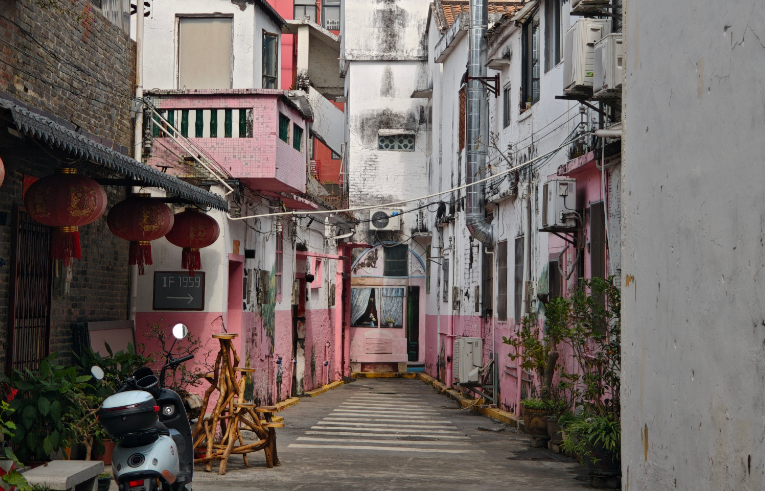

In [ ]:
import cv2
import numpy as np
import random
import io
from PIL import Image

from IPython.display import display, Image
demo = Image(filename='ex.png')
display(demo)

对图像进行模糊：

随机参数：kernel_size=3, sigma=1.9933096420957221


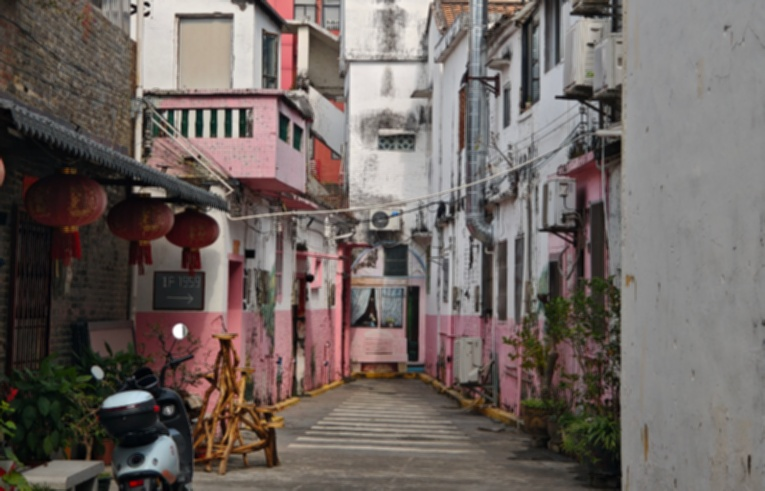

In [228]:
# 1. 高斯模糊

img = cv2.imread('ex.png')
kernel_size = random.choice([3, 5, 7, 9, 11, 13]) # 随机选择卷积核大小
sigma = random.uniform(0.1, 3.0) # 随机选择sigma值
# 使用cv2的高斯模糊函数进行模糊处理
blurred_img = cv2.GaussianBlur(img, (kernel_size, kernel_size), sigma)

# 显示模糊后的图片
cv2.imwrite('blurred_ex.jpg', blurred_img)
print(r'随机参数：kernel_size={}, sigma={}'.format(kernel_size, sigma))
display(Image(filename='blurred_ex.jpg'))

对图像进行下采样：

随机参数：scale_factor=0.46204291154115806, down_method=2


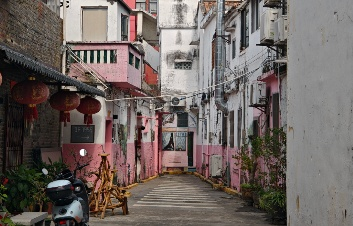

In [226]:
# 2. 下采样
scale_factor = random.uniform(0.25, 0.5)  # 随机选择缩放因子
h, w = img.shape[:2]
new_h, new_w = int(h * scale_factor), int(w * scale_factor)

# 使用cv2的resize函数进行下采样
down_method = random.choice([cv2.INTER_NEAREST, cv2.INTER_LINEAR, cv2.INTER_CUBIC])
downsampled = cv2.resize(blurred_img, (new_w, new_h), interpolation=down_method)

# 显示下采样后的图片
cv2.imwrite('downsampled_ex.jpg', downsampled)
print(r'随机参数：scale_factor={}, down_method={}'.format(scale_factor, down_method))
display(Image(filename='downsampled_ex.jpg'))

对图像增加噪声：

随机参数：noise_type=poisson, var=0.04799332812902406


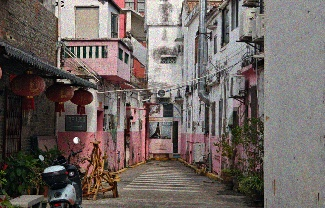

In [217]:
# 3. 增加噪声
noise_type = random.choice(['gaussian', 'poisson']) # 随机选择噪声类型
if noise_type == 'gaussian':
    # 生成高斯噪声
    mean = 0
    var = random.uniform(0.001, 0.05)
    sigma = var ** 0.5
    gauss = np.random.normal(mean, sigma, downsampled.shape).astype(np.float32)
    noisy = np.clip(downsampled + gauss * 255, 0, 255).astype(np.uint8)
else:
    # 生成泊松噪声
    noisy = np.random.poisson(downsampled / 255.0 * 255) / 255.0 * 255
    noisy = np.clip(noisy, 0, 255).astype(np.uint8)

# 显示添加噪声后的图片
print(r'随机参数：noise_type={}, var={}'.format(noise_type, var))
cv2.imwrite('noisy_ex.jpg', noisy)
display(Image(filename='noisy_ex.jpg'))

对图像执行JPEG压缩：

随机参数：quality=44


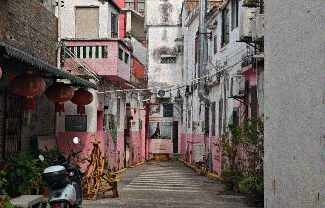

In [218]:
# 4.JPEG压缩

quality = random.randint(10, 50)  # 随机选择压缩质量

# 使用cv2的imencode函数进行JPEG压缩
encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
_, encimg = cv2.imencode('.jpg', noisy, encode_param)

# 显示JPEG压缩后的图片
jpeg_compressed = cv2.imdecode(encimg, 1)
cv2.imwrite('jpeg_compressed_ex.jpg', jpeg_compressed)
print(r'随机参数：quality={}'.format(quality))
display(Image(filename='jpeg_compressed_ex.jpg'))

对于上面经典的退化模型，可能无法生成现实中一些未知的噪声和复杂的伪影，为此作者提出了一种高阶的退化模型，这个n阶模型包含n个重复的退化步骤，每个步骤都执行一次上面的经典退化模型。过程相同，但超参数不同。
$$
\mathbf{x} = \mathcal{D}^n(\mathbf{y}) = (\mathcal{D}_n \circ \cdots \circ \mathcal{D}_2 \circ \mathcal{D}_1)(\mathbf{y}).
$$
作者在经验上最终选择了二阶退化，它在经典退化模型的基础上再执行了一次过程相同但参数不同的过程，并在退化链的最后执行了一个2D sinc 滤波器：
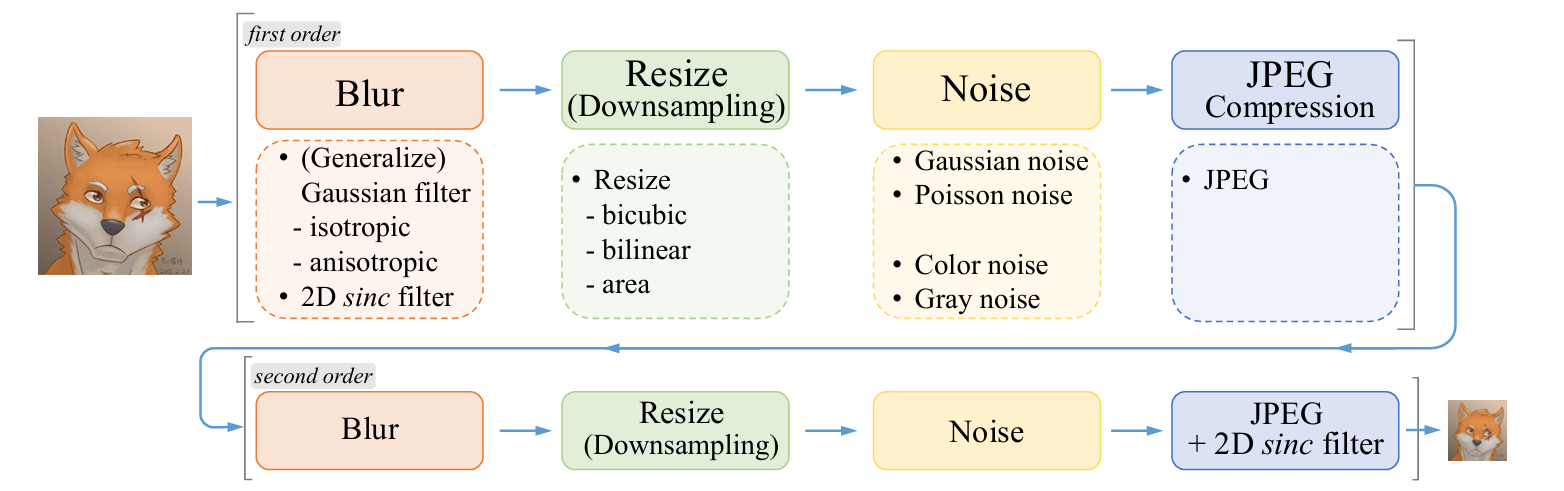

>2D sinc 滤波器在图像处理中是一种理想的低通滤波器，其在空间域中的表现与傅里叶变换中的矩形函数相对应。sinc 函数定义为 $\text{sinc}(x) = \begin{cases} \frac{\sin(\pi x)}{\pi x} & \text{if } x \neq 0 \\1 & \text{if } x = 0 \end{cases}$ 。在二维图像处理中，2D sinc 滤波器通过在两个维度上应用 sinc 函数来平滑图像，同时尽可能保留图像的高频细节。这种滤波器在图像的下采样过程中特别有用，因为它可以减少混叠效应，即高频信号错误地表现为低频信号的现象。在实际应用中，2D sinc 滤波器通常与窗函数（如汉宁窗、汉明窗等）结合使用，以改善滤波器的边缘效应并避免振铃现象。